<a href="https://colab.research.google.com/github/AnacletoLAB/grape/blob/main/notebooks/Using_CBOW_to_embed_Cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using CBOW to compute Cora's node embedding
In the following tutorial we will compute Cora's node embedding using CBOW, both using the high-level pipeline and the model itself.

We start by installing the GraPE library:

```bash
pip install grape -U
```

We assume you have already properly set up TensorFlow on your machine with it running within a GPU or similar hardware accelerator. If you do not have a similar setup available in your system, the GraPE library will warn you before proceeding further because running these models without a GPU will be significantly slower. You can learn more about properly setupping your TensorFlow on GPU [here](https://www.tensorflow.org/install/gpu).

A valid alternative is to run this tutorial on COLAB.

In [ ]:
!pip install -q grape -U

Additionally, we install also some other dependencies we will be using during the tutorial.

In [ ]:
!pip install -q plot_keras_history seedir silence_tensorflow
!pip install -q tsnecuda==3.0.0+cu110 -f https://tsnecuda.isx.ai/tsnecuda_stable.html --no-dependencies
!pip install -q faiss

In [ ]:
# In order to disable 
import silence_tensorflow.auto

## Retrieving Cora
We will now proceed to retrieve the Cora graph, using Ensmallen's automatic graph retrieval. You can learn more about the automatic graph retrieval in [add tutorial reference here].

In [ ]:
from ensmallen.datasets.linqs import Cora
from ensmallen.datasets.linqs.parse_linqs import get_words_data

In [ ]:
graph, node_features = get_words_data(Cora())

Extracting words features:   0%|          | 0/4141 [00:00<?, ?it/s]

### Taking a look at the graph report

In [ ]:
graph

<h2>Cora</h2><p>The undirected graph Cora has 2708 heterogenous nodes and 5278 homogeneous edges.</p><h3>RAM requirements</h3><p>The RAM requirements for the nodes and edges data structures are 399.52KB and 16.26KB respectively.</p><h3>Degree centrality</h3><p>The minimum node degree is 1, the maximum node degree is 168, the mode degree is 2, the mean degree is 3.90 and the node degree median is 3.</p><p>The nodes with highest degree centrality are: 35 (degree 168 and node type Genetic_Algorithms), 6213 (degree 78 and node type Reinforcement_Learning), 1365 (degree 74 and node type Neural_Networks), 3229 (degree 65 and node type Neural_Networks) and 910 (degree 44 and node type Neural_Networks).</p><h3>Node types</h3><p>The graph has 7 node types, of which the 5 most common are Neural_Networks (818 nodes, 30.21%), Probabilistic_Methods (426 nodes, 15.73%), Genetic_Algorithms (418 nodes, 15.44%), Theory (351 nodes, 12.96%) and Case_Based (298 nodes, 11.00%).</p><h4>RAM requirements</h4><p>The RAM requirements for the node types data structure is 136.99KB.</p><h3>Edge types</h3><p>The graph has a single edge type, which is Paper2Paper. Note that this means that all edges have the same edge type, that is, all edges are homogeneous..</p><h4>RAM requirements</h4><p>The RAM requirements for the edge types data structure is 42.61KB.</p>

### Taking a look at the node features
Even though the CBOW model does not take in consideration the node features, these values are available for Cora so let's take a look.

In [ ]:
node_features

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11,word_12,word_13,word_14,word_15,word_16,word_17,word_18,word_19,word_20,word_21,word_22,word_23,word_24,word_25,word_26,word_27,word_28,word_29,word_30,word_31,word_32,word_33,word_34,word_35,word_36,word_37,word_38,word_39,...,word_1393,word_1394,word_1395,word_1396,word_1397,word_1398,word_1399,word_1400,word_1401,word_1402,word_1403,word_1404,word_1405,word_1406,word_1407,word_1408,word_1409,word_1410,word_1411,word_1412,word_1413,word_1414,word_1415,word_1416,word_1417,word_1418,word_1419,word_1420,word_1421,word_1422,word_1423,word_1424,word_1425,word_1426,word_1427,word_1428,word_1429,word_1430,word_1431,word_1432
31336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1061127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1128978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117328,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,

## Running CBOW from the default pipeline

### First-order random walk based sampling

0epoch [00:00, ?epoch/s]

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f15703cdf10>,
       dtype=object))

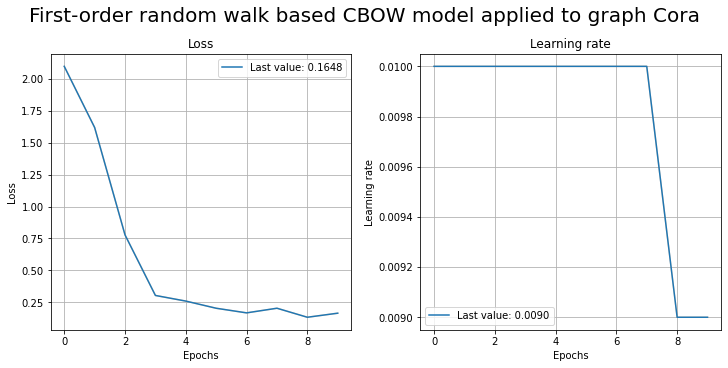

In [ ]:
from embiggen.pipelines import compute_node_embedding
from plot_keras_history import plot_history

node_embedding_method_name = "CBOW"

first_order_rw_node_embedding, training_history = compute_node_embedding(
    graph,
    node_embedding_method_name=node_embedding_method_name,
)

plot_history(
    training_history,
    title="First-order random walk based {} model applied to graph {}".format(
        node_embedding_method_name,
        graph.get_name()
    )
)

Let's take a look at the obtained node embedding:

In [ ]:
first_order_rw_node_embedding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
35,0.029923,0.190110,0.030551,-0.147623,-0.068837,-0.036551,-0.043253,0.179046,-0.101827,-0.210755,0.022166,0.194410,-0.053166,0.264329,0.074969,-0.032092,-0.000038,0.241642,-0.089606,-0.188775,0.043387,0.009871,0.174358,0.132187,0.000818,0.122536,-0.229718,-0.248901,0.346846,0.011163,-0.075779,-0.019147,0.011468,0.256398,0.152131,0.282992,-0.026209,-0.263249,0.171631,-0.060458,...,-0.032632,0.149950,-0.254537,-0.131363,-0.297488,-0.330186,0.118923,0.018790,0.159748,0.181748,-0.176611,-0.273212,0.012456,-0.368891,-0.313863,-0.053058,-0.227891,-0.042239,-0.135443,0.065539,0.203802,-0.003612,-0.011934,0.011074,0.265405,0.191824,0.300741,0.108703,0.258770,-0.233025,0.300786,0.200719,0.015077,-0.063524,0.125429,-0.309594,0.415062,-0.233017,-0.275859,-0.333939
6213,-0.310102,-0.307174,-0.030360,0.314731,0.104907,0.194488,-0.003270,-0.308585,0.270427,0.239299,-0.098816,0.128396,-0.137499,0.387124,-0.091147,-0.230076,-0.127526,-0.128295,-0.176149,-0.324862,-0.244565,0.044415,0.262356,-0.343668,-0.187510,0.172036,-0.360432,0.399033,-0.331025,0.094859,-0.207681,-0.148462,-0.353999,0.445523,-0.379735,-0.491437,-0.048941,-0.063629,-0.407421,0.367497,...,0.099469,-0.044940,0.298942,0.025000,0.087009,-0.324143,0.275845,-0.022652,-0.009233,0.116839,-0.012509,-0.269906,-0.347923,0.091355,0.171700,-0.307644,0.311199,0.227903,-0.077197,0.197206,-0.284913,0.117526,0.191922,0.106779,0.153767,-0.103944,-0.222396,-0.083175,-0.303674,0.181948,0.001584,-0.037920,-0.335360,-0.215129,0.179402,-0.432352,0.342905,0.305586,0.347087,0.135664
1365,0.238111,-0.360038,-0.325846,-0.396765,0.245237,0.408732,0.122508,0.299602,0.362996,0.283151,-0.232797,-0.240943,0.239808,-0.334857,-0.356864,-0.237039,-0.258655,-0.332047,0.404812,0.299630,0.371945,0.180869,0.269816,-0.428342,-0.346877,0.319948,-0.432367,0.390761,-0.150617,0.275767,-0.248783,0.414482,0.348261,0.388729,0.202037,0.026093,-0.171098,-0.435013,-0.441610,0.465356,...,0.293181,-0.154906,-0.369045,0.260810,0.302457,0.264287,0.310785,-0.187225,0.221379,0.345544,-0.289125,0.365456,-0.374213,0.305981,0.371965,-0.366132,0.439269,0.251148,0.281114,-0.381238,0.389478,-0.395321,-0.194752,0.245371,-0.277628,0.444469,-0.282241,0.101451,-0.389737,0.339133,0.356090,0.336179,-0.403793,-0.037492,-0.360864,0.228493,-0.269387,0.421017,0.347845,0.321246
3229,0.173535,-0.223708,-0.119375,-0.298334,0.350288,0.309839,0.231425,0.517319,0.461820,0.138326,-0.123442,-0.266871,0.276178,-0.326043,-0.198425,-0.461707,-0.311307,0.352991,-0.060312,0.371354,0.161757,0.198598,0.401824,-0.078059,-0.238951,0.248109,-0.248319,0.319452,-0.452864,0.262758,-0.021163,-0.029875,-0.213390,-0.247792,0.199606,0.322008,-0.026459,0.238085,0.230053,-0.161378,...,-0.155866,-0.256365,-0.394695,0.226507,0.185758,-0.349557,-0.466054,-0.171827,-0.407140,0.198084,-0.352973,0.378014,-0.358757,0.191100,0.085314,-0.164539,0.283630,0.350479,-0.037371,-0.366418,0.493902,-0.006187,-0.044319,0.297789,0.393429,0.375726,-0.247618,0.181487,-0.239177,0.041779,-0.165265,0.210699,-0.335246,-0.160329,-0.481117,0.048526,0.285602,0.286348,-0.234025,0.171510
910,-0.534439,0.388485,-0.277444,-0.358324,0.412045,0.334503,0.191495,0.028642,-0.175127,0.271672,-0.231391,-0.236953,0.317238,-0.309273,-0.171555,0.154090,-0.218037,0.200230,-0.062201,0.360168,0.229001,-0.059438,-0.391305,0.302686,-0.017869,0.280717,0.021116,0.268761,-0.348223,-0.068568,-0.332675,-0.156895,0.270469,0.339724,-0.215825,-0.510408,-0.225118,-0.367878,0.479742,-0.069730,...,0.170142,-0.182301,-0.092299,0.097194,0.249040,0.317936,0.233786,-0.018800,-0.257033,-0.460592,-0.159379,0.169461,-0.421111,0.318834,0.435372,-0.357680,0.435697,0.091630,0.458830,-0.204741,-0.241632,-0.389326,-0.139680,-0.017584,0.444411,-0.319019,-0.276255,0.356578,-0.305855,-0.250119,-0.372874,0.1232

Note that the `compute_node_embedding` method also automatically handles the caching of the computed node embedding, and it is all made available in the node embeddings directory:

In [ ]:
from seedir import seedir

seedir("node_embeddings")

node_embeddings/
└─CBOW/
  └─Cora/
    ├─9f5d0824d7b476a4d167cab361c0e3bfb595c2e417fe6d9414ea5ac969ebed47_embedding.pkl.gz
    ├─ea133954408c3a08e8a15fd44bbf2c88b7d79552ae4bc2b63b9403d423815db1_embedding.pkl.gz
    ├─1fbd734e74eaade42639667e7f0e45e4ff62400d1e16bd00fa714af92c7ee83f_embedding.pkl.gz
    ├─9f5d0824d7b476a4d167cab361c0e3bfb595c2e417fe6d9414ea5ac969ebed47_training_history.csv.xz
    ├─1fbd734e74eaade42639667e7f0e45e4ff62400d1e16bd00fa714af92c7ee83f_training_history.csv.xz
    ├─9f5d0824d7b476a4d167cab361c0e3bfb595c2e417fe6d9414ea5ac969ebed47_training_history.csv.xz.metadata
    ├─5101f9053bec131de1b3d8073bbaff701859718de2ce9366976b7cdfff84b7b4_embedding.pkl.gz.metadata
    ├─9f5d0824d7b476a4d167cab361c0e3bfb595c2e417fe6d9414ea5ac969ebed47_embedding.pkl.gz.metadata
    ├─ea133954408c3a08e8a15fd44bbf2c88b7d79552ae4bc2b63b9403d423815db1_training_history.csv.xz.metadata
    ├─ea133954408c3a08e8a15fd44bbf2c88b7d79552ae4bc2b63b9403d423815db1_embedding.pkl.gz.metadata
    ├─5101f9

### Second-order random walk based sampling
In some cases, one may want to use the Node2Vec sampling, which is a second-order random walk based sampling.

0epoch [00:00, ?epoch/s]

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1522600950>,
       dtype=object))

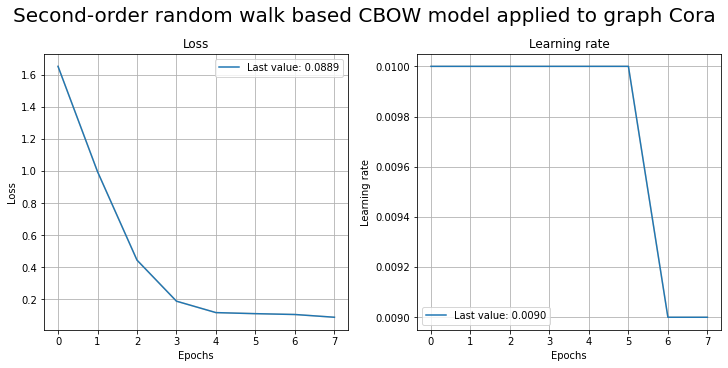

In [ ]:
from embiggen.pipelines import compute_node_embedding
from plot_keras_history import plot_history

node_embedding_method_name = "CBOW"

second_order_rw_node_embedding, training_history = compute_node_embedding(
    graph,
    node_embedding_method_name=node_embedding_method_name,
    # Let's increase the probability of explore the local neighbourhood
    return_weight=2.0,
    explore_weight=0.1
)

plot_history(
    training_history,
    title="Second-order random walk based {} model applied to graph {}".format(
        node_embedding_method_name,
        graph.get_name()
    )
)

Let's take a look at this new embedding

In [ ]:
second_order_rw_node_embedding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
35,-0.217345,-0.089519,-0.277746,-0.345621,-0.285573,0.223163,0.269251,0.162250,0.038539,-0.335871,0.143295,0.232627,-0.120077,-0.318980,-0.289594,-0.312747,-0.357357,-0.215436,-0.058010,-0.130657,-0.149778,-0.183516,0.113448,0.348171,0.095151,-0.055963,0.257727,-0.269816,-0.052577,-0.187715,0.307998,-0.135228,-0.288506,0.262695,0.280981,-0.235849,0.319036,0.317801,-0.353015,0.225980,...,0.251805,0.137284,0.302654,0.126568,-0.090154,0.174972,0.192121,-0.387092,-0.268039,-0.266601,-0.251230,0.280286,0.248079,0.283015,0.355410,-0.316712,-0.300036,0.155314,-0.180918,-0.200807,0.289040,0.370658,0.340966,-0.215084,-0.339530,0.322839,0.301199,0.206985,0.370766,-0.086517,0.291224,0.000380,0.209049,0.137486,-0.312386,-0.167653,0.293402,-0.302732,0.234474,-0.318239
6213,-0.281997,-0.059767,-0.057123,0.320024,-0.006716,-0.293457,0.240170,0.423745,0.248757,0.356998,0.398841,-0.483569,0.201834,0.264572,-0.216199,-0.027287,0.159305,-0.401948,-0.515766,-0.172059,0.377690,0.284384,0.019801,0.373097,0.371274,0.009558,0.287453,-0.300169,-0.208869,0.331766,0.289465,-0.123865,0.333281,0.063924,0.065558,-0.437095,-0.090702,0.436357,-0.058224,-0.128266,...,0.317011,-0.360903,0.342010,0.209461,0.255775,-0.118741,0.303057,-0.291028,0.244859,-0.391476,-0.245367,0.267913,0.101567,0.101718,-0.303228,0.233550,0.134178,0.179871,0.406250,-0.169599,-0.281262,0.242470,-0.299135,-0.205005,0.238762,0.241174,-0.014051,0.361022,-0.216306,-0.342700,0.078129,0.008472,-0.386537,-0.247001,-0.398976,-0.181078,0.109287,0.335650,0.274059,0.249605
1365,0.468521,0.247039,-0.347811,-0.477703,0.356209,-0.245407,-0.323704,-0.308759,-0.303044,0.312277,0.017316,-0.303236,0.393351,-0.433475,0.280237,-0.200362,0.149533,-0.306056,-0.424021,-0.263957,0.284154,0.310699,-0.003571,0.112508,0.210862,0.327408,0.395017,-0.239078,-0.265516,-0.007110,-0.424083,-0.255820,0.361636,-0.275273,0.363655,-0.064295,-0.027980,-0.376320,0.035844,-0.360554,...,0.381757,0.322788,0.301867,-0.143183,-0.357167,-0.384844,-0.117579,-0.293110,0.253794,-0.351052,-0.456065,0.158403,0.381754,0.139052,-0.322011,0.341925,-0.294052,0.267662,-0.243848,-0.330107,-0.198815,-0.382561,-0.325493,-0.232243,0.122614,-0.329897,-0.516994,0.324793,-0.481022,-0.344058,-0.399860,-0.076208,-0.303224,-0.477986,-0.181633,-0.325660,0.065767,-0.105946,0.306768,0.232709
3229,-0.012354,0.208913,0.361743,-0.504275,-0.168921,-0.417130,-0.339078,-0.270921,0.084550,0.061878,-0.450550,-0.088532,0.395349,-0.329415,0.319024,-0.413744,-0.312590,-0.184355,-0.323275,-0.388661,0.148509,-0.234738,-0.306551,-0.239305,0.032866,-0.168475,0.203000,0.373048,-0.128481,0.364190,-0.397680,-0.471016,0.451100,0.204895,0.155086,-0.104905,-0.269858,0.124498,0.389216,-0.220141,...,0.267863,-0.313742,0.420228,-0.378727,-0.256749,-0.206283,-0.436871,-0.248896,0.107967,0.080151,-0.384380,0.315839,0.174223,0.355495,0.162010,0.309064,-0.372425,-0.064418,-0.372505,-0.003612,-0.368454,-0.232971,-0.325014,0.219453,-0.255636,0.421568,-0.302623,0.267097,-0.001459,-0.395704,-0.411113,0.383837,0.228864,-0.304950,-0.445061,-0.390235,-0.167141,0.323221,0.404818,-0.331512
910,-0.147748,0.097535,0.178026,-0.432132,0.160776,-0.404942,-0.377408,-0.231291,-0.253573,0.432518,0.152228,-0.426517,-0.162492,-0.339661,0.277125,-0.232610,-0.207116,0.413661,-0.500745,-0.152260,0.323650,0.167577,-0.038458,-0.083537,0.466314,0.091650,0.078521,0.027946,-0.135540,0.247856,-0.343555,-0.426804,-0.137451,-0.043355,-0.301802,0.269500,-0.046486,-0.135942,0.456658,-0.412921,...,0.079694,0.352921,-0.297004,-0.119384,0.450223,-0.124342,-0.079793,-0.211262,-0.230702,0.533709,0.294628,0.199797,-0.060361,0.123265,0.067736,0.363649,-0.176336,0.195887,-0.167523,-0.350253,0.107908,0.114331,-0.125232,0.432913,0.022328,0.171955,-0.465344,-0.006333,-0.569082,0.079318,-0.

We can see that in the cache directory are now present two node embeddings.

In [ ]:
from seedir import seedir

seedir("node_embeddings")

node_embeddings/
└─CBOW/
  └─Cora/
    ├─9f5d0824d7b476a4d167cab361c0e3bfb595c2e417fe6d9414ea5ac969ebed47_embedding.pkl.gz
    ├─53678e2f40a97b5d39e3b37aa6d4fd520c6020b197d3cd9437dfebd6e7cb9847_embedding.pkl.gz
    ├─ea133954408c3a08e8a15fd44bbf2c88b7d79552ae4bc2b63b9403d423815db1_embedding.pkl.gz
    ├─1fbd734e74eaade42639667e7f0e45e4ff62400d1e16bd00fa714af92c7ee83f_embedding.pkl.gz
    ├─53678e2f40a97b5d39e3b37aa6d4fd520c6020b197d3cd9437dfebd6e7cb9847_training_history.csv.xz.metadata
    ├─9f5d0824d7b476a4d167cab361c0e3bfb595c2e417fe6d9414ea5ac969ebed47_training_history.csv.xz
    ├─53678e2f40a97b5d39e3b37aa6d4fd520c6020b197d3cd9437dfebd6e7cb9847_training_history.csv.xz
    ├─1fbd734e74eaade42639667e7f0e45e4ff62400d1e16bd00fa714af92c7ee83f_training_history.csv.xz
    ├─9f5d0824d7b476a4d167cab361c0e3bfb595c2e417fe6d9414ea5ac969ebed47_training_history.csv.xz.metadata
    ├─5101f9053bec131de1b3d8073bbaff701859718de2ce9366976b7cdfff84b7b4_embedding.pkl.gz.metadata
    ├─9f5d0824d7b476a4d

## Using directly the model
Instead of using the high level pipeline, it is surely possible also to use the CBOW model directly. Note that using directly CBOW there won't be applied automatically the distribution strategy across different GPUs, if any, no caching mechanism will be used and no checks will be executed validating the health of your TensorFlow installation (whether GPU drivers are available etc...). 

In [ ]:
from embiggen import GraphCBOW

All of the embedding models have the relative documentation, that you can always read by using the help command:

In [ ]:
help(GraphCBOW)

Help on class GraphCBOW in module embiggen.embedders.graph_cbow:

class GraphCBOW(embiggen.embedders.node2vec.Node2Vec)
 |  GraphCBOW(graph: Graph, embedding_size: int = 100, embedding: Union[numpy.ndarray, pandas.core.frame.DataFrame] = None, extra_features: Union[numpy.ndarray, pandas.core.frame.DataFrame] = None, optimizer: Union[str, keras.optimizer_v2.optimizer_v2.OptimizerV2] = None, negative_samples: int = 10, walk_length: int = 128, batch_size: int = 256, iterations: int = 16, window_size: int = 4, return_weight: float = 1.0, explore_weight: float = 1.0, change_node_type_weight: float = 1.0, change_edge_type_weight: float = 1.0, max_neighbours: int = None, elapsed_epochs: int = 0, support_mirrored_strategy: bool = False, random_state: int = 42, dense_node_mapping: Dict[int, int] = None, use_gradient_centralization: bool = True)
 |  
 |  GraphCBOW model for graph embedding.
 |  
 |  The GraphCBOW model for graoh embedding receives a list of contexts and tries
 |  to predict the 

We need to sort the graph nodes according to the decreasing node degree in order to exploit the Zipfian sampling, which guaranties a better approximation of the Softmax.

In [ ]:
model = GraphCBOW(
    graph.sort_by_decreasing_outbound_node_degree()
)

In [ ]:
history = model.fit()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1516a67fd0>,
       dtype=object))

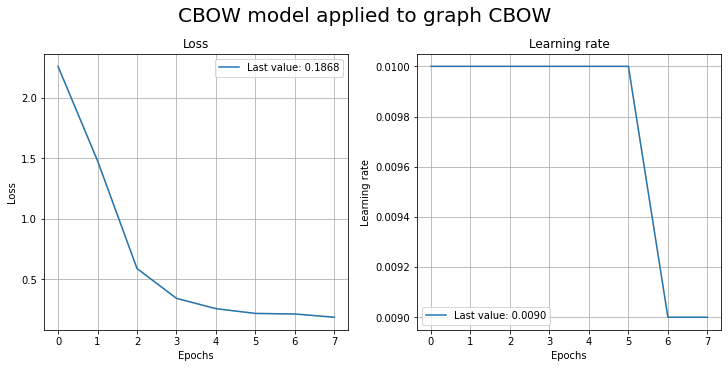

In [ ]:
plot_history(
    history,
    title="CBOW model applied to graph {}".format(
        node_embedding_method_name,
        graph.get_name()
    )
)

In [ ]:
node_embedding = model.get_embedding_dataframe()

In [ ]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
35,-0.059282,0.290230,0.288817,0.348804,0.081569,0.297870,0.210350,0.283565,0.094658,-0.108465,-0.257377,-0.131942,0.169815,-0.107033,0.047787,0.283255,-0.208632,-0.229485,-0.223239,-0.129952,-0.009396,-0.073839,0.048333,-0.315387,0.273249,0.103815,-0.320077,-0.066954,0.098804,-0.171828,-0.216711,-0.341409,-0.250982,-0.256181,0.376592,0.034621,0.110807,-0.195757,0.117001,0.140027,...,-0.005860,0.117866,-0.130275,-0.456574,0.140920,-0.267641,-0.245789,0.159254,0.222737,0.305196,0.281726,-0.072247,-0.212258,0.124106,0.132834,-0.052647,-0.348383,0.250537,0.352303,-0.044213,0.117858,-0.165971,0.261850,-0.349932,0.256940,-0.003775,0.278268,0.203957,-0.170395,0.138638,-0.284037,-0.003176,-0.345775,-0.192738,0.253221,-0.204592,-0.168457,0.161570,-0.205661,0.210461
6213,-0.172571,-0.270122,0.147008,-0.348706,-0.251642,0.203228,0.261682,0.358735,0.056098,0.385590,-0.121344,-0.238077,-0.307225,0.041816,0.255956,-0.276238,0.323359,0.199656,0.176319,0.279144,0.185695,-0.178580,0.112815,-0.291637,0.278996,-0.243005,0.253818,-0.409259,0.058505,-0.135413,-0.194120,0.240268,-0.261812,0.019356,-0.415977,0.100005,0.187043,-0.175784,-0.028042,-0.228585,...,-0.100090,-0.227549,-0.256689,-0.365237,0.219157,0.108207,0.048714,0.200864,0.252775,0.193763,0.261907,-0.047147,0.288526,0.308633,0.157154,-0.082143,0.172141,-0.133138,-0.248938,-0.014560,0.113317,0.428647,0.307912,0.372715,0.163665,-0.197432,0.282492,-0.306864,0.285928,0.005707,0.286989,0.163494,-0.388569,-0.270217,0.266796,-0.063797,0.365450,0.053621,-0.186262,0.075314
1365,-0.312157,-0.182911,0.247190,-0.347732,-0.044625,-0.312488,-0.365526,-0.073682,0.306008,-0.181756,-0.269489,0.394052,0.331117,0.425786,0.386460,0.348955,-0.291441,-0.338424,-0.280848,0.429492,0.195713,0.324925,0.340396,0.179977,0.468023,-0.477602,-0.324653,-0.373522,-0.454367,0.344698,0.119880,-0.301213,0.390150,0.393806,-0.375939,0.040821,0.306222,-0.369194,-0.445238,-0.431507,...,0.124725,-0.428848,-0.339110,0.347721,0.371684,-0.252140,-0.424269,-0.271464,0.285708,0.412103,0.170976,-0.440534,0.375184,-0.316155,-0.414175,0.255360,-0.404264,0.352412,0.058175,0.328744,-0.431692,0.436195,0.399371,0.407680,-0.413260,-0.346387,-0.415449,0.339046,-0.349617,0.398971,0.333426,0.297435,0.262226,-0.312432,0.387780,-0.379513,0.390026,-0.351945,-0.390394,-0.380130
3229,-0.336911,0.274392,0.286438,-0.340667,0.155749,-0.041052,-0.320472,-0.331445,-0.049391,-0.241179,-0.268980,0.239153,0.460625,0.452404,0.394730,0.409673,-0.340928,0.238866,0.276446,0.209747,0.291903,-0.158685,0.276937,-0.332672,0.497153,-0.309019,-0.387557,0.044870,-0.536457,0.444813,-0.369674,-0.463129,-0.309831,-0.267775,-0.411683,0.338319,-0.351823,-0.439603,-0.392000,-0.448763,...,-0.161673,-0.385444,-0.406679,0.301488,0.324471,-0.458239,0.252077,0.039758,-0.126850,0.361979,-0.160260,-0.304079,0.432145,-0.207902,-0.002666,-0.185023,-0.125203,-0.003008,0.389168,0.151252,-0.391270,0.405049,0.411527,0.380015,-0.383710,-0.311649,-0.169778,0.229439,-0.403746,0.341844,-0.355350,-0.074058,0.216454,0.191434,0.439346,-0.174773,-0.296609,0.323652,-0.338134,0.105635
910,-0.187253,-0.329317,-0.432377,-0.396536,-0.118708,0.281331,0.075368,0.390394,0.206649,0.382015,0.348394,0.359635,-0.269906,0.410318,0.355862,0.318986,-0.375745,-0.375465,0.412021,-0.412451,0.343876,-0.303836,0.073022,-0.068667,0.402197,-0.313774,-0.310405,-0.374469,-0.202339,0.393379,-0.290223,-0.460387,-0.033236,0.297318,-0.315003,0.293018,0.368248,0.203398,0.307372,-0.427600,...,0.156504,-0.474445,-0.248333,0.349498,0.074708,0.187574,0.315674,-0.235989,0.196011,-0.357941,0.391132,-0.116292,0.252975,0.336224,-0.463827,0.321558,-0.285060,-0.276338,-0.401350,0.183114,0.062060,-0.241516,0.345009,-0.322244,-0.395200,0.164267,-0.525447,0.424622,-0.355528,0.278374,0.425767,-0.482542,

## Graph visualization
Let's now visualize the two node embeddings. We can use the graph visualization tool available from the Embiggen module.

In [ ]:
from embiggen.visualizations import GraphVisualization

We create the visualizer object.

In [ ]:
visualizer = GraphVisualization(graph, node_embedding_method=node_embedding_method_name)

And we embedd the node embedding further into a 2D embedding using TSNE (by default), and since we have installed [tsnecude](https://github.com/CannyLab/tsne-cuda) at the beginning of this notebook, the library will automatically use it as it is one of the best TSNE implementations we know of.

In [ ]:
visualizer.fit_transform_nodes(first_order_rw_node_embedding)

(<Figure size 1400x1400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1514ddfbd0>)

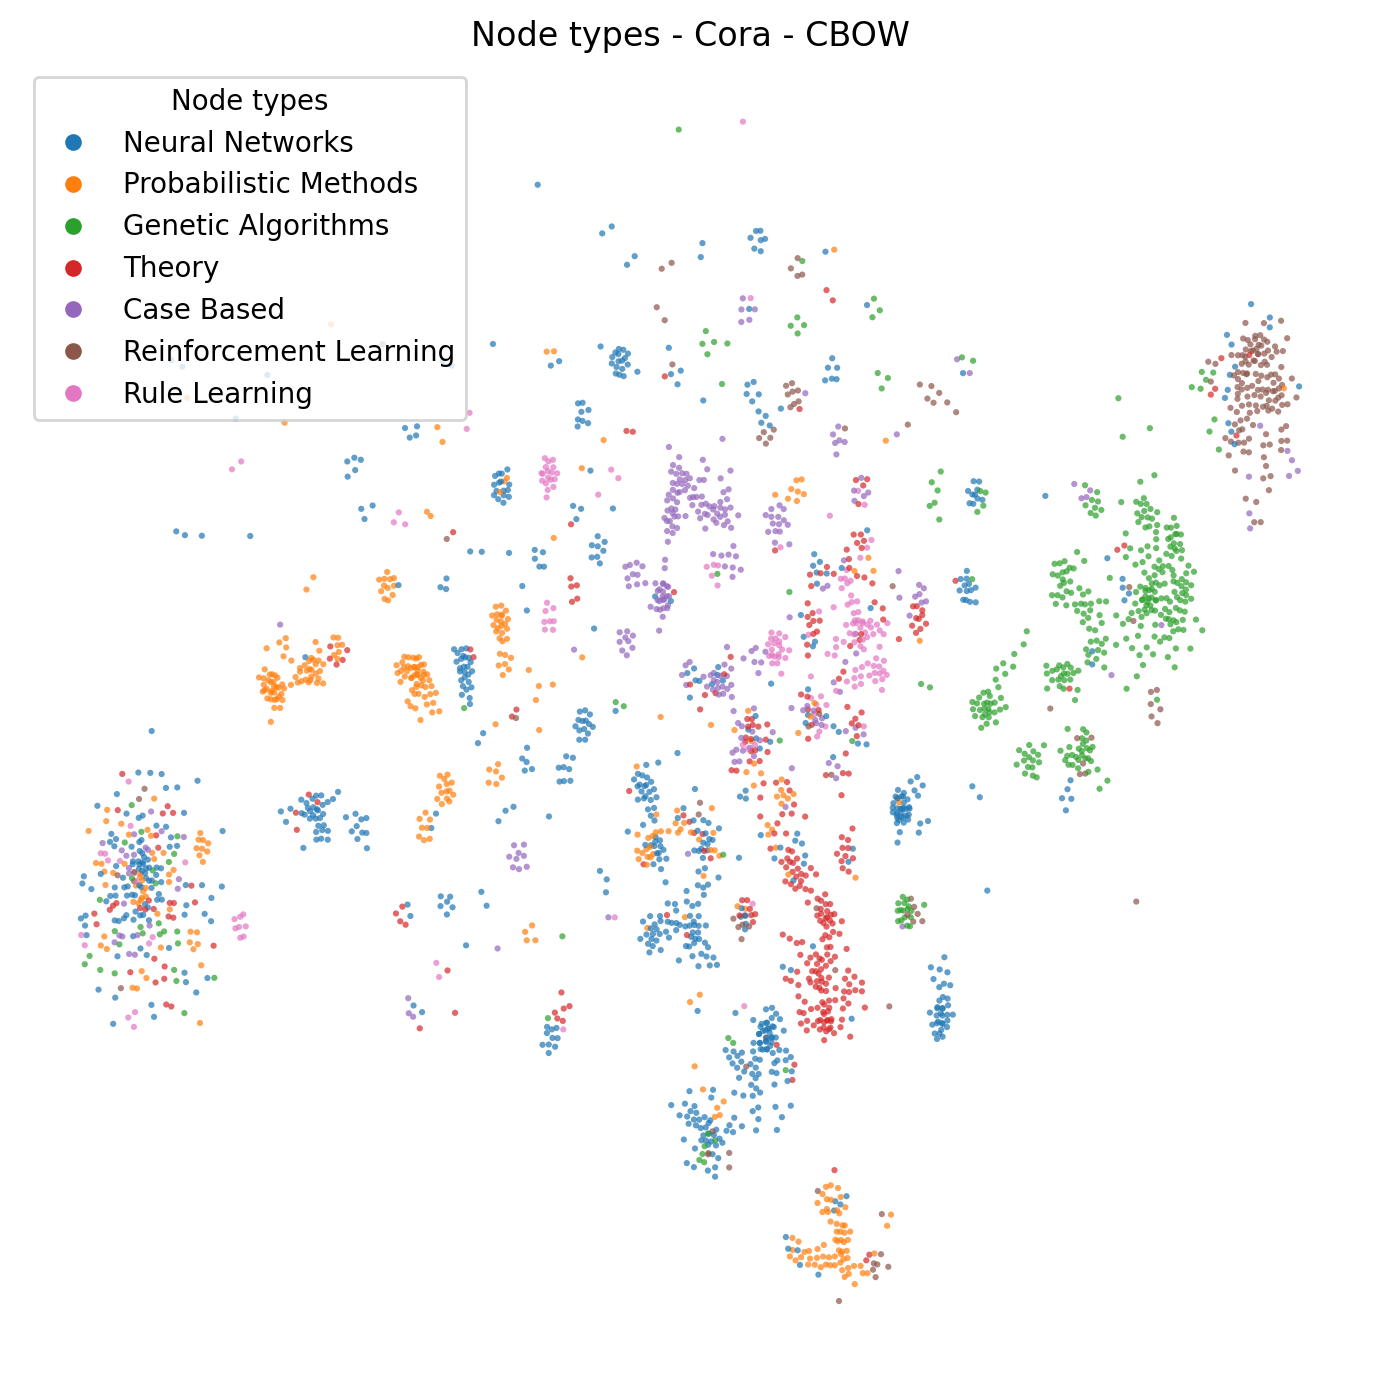

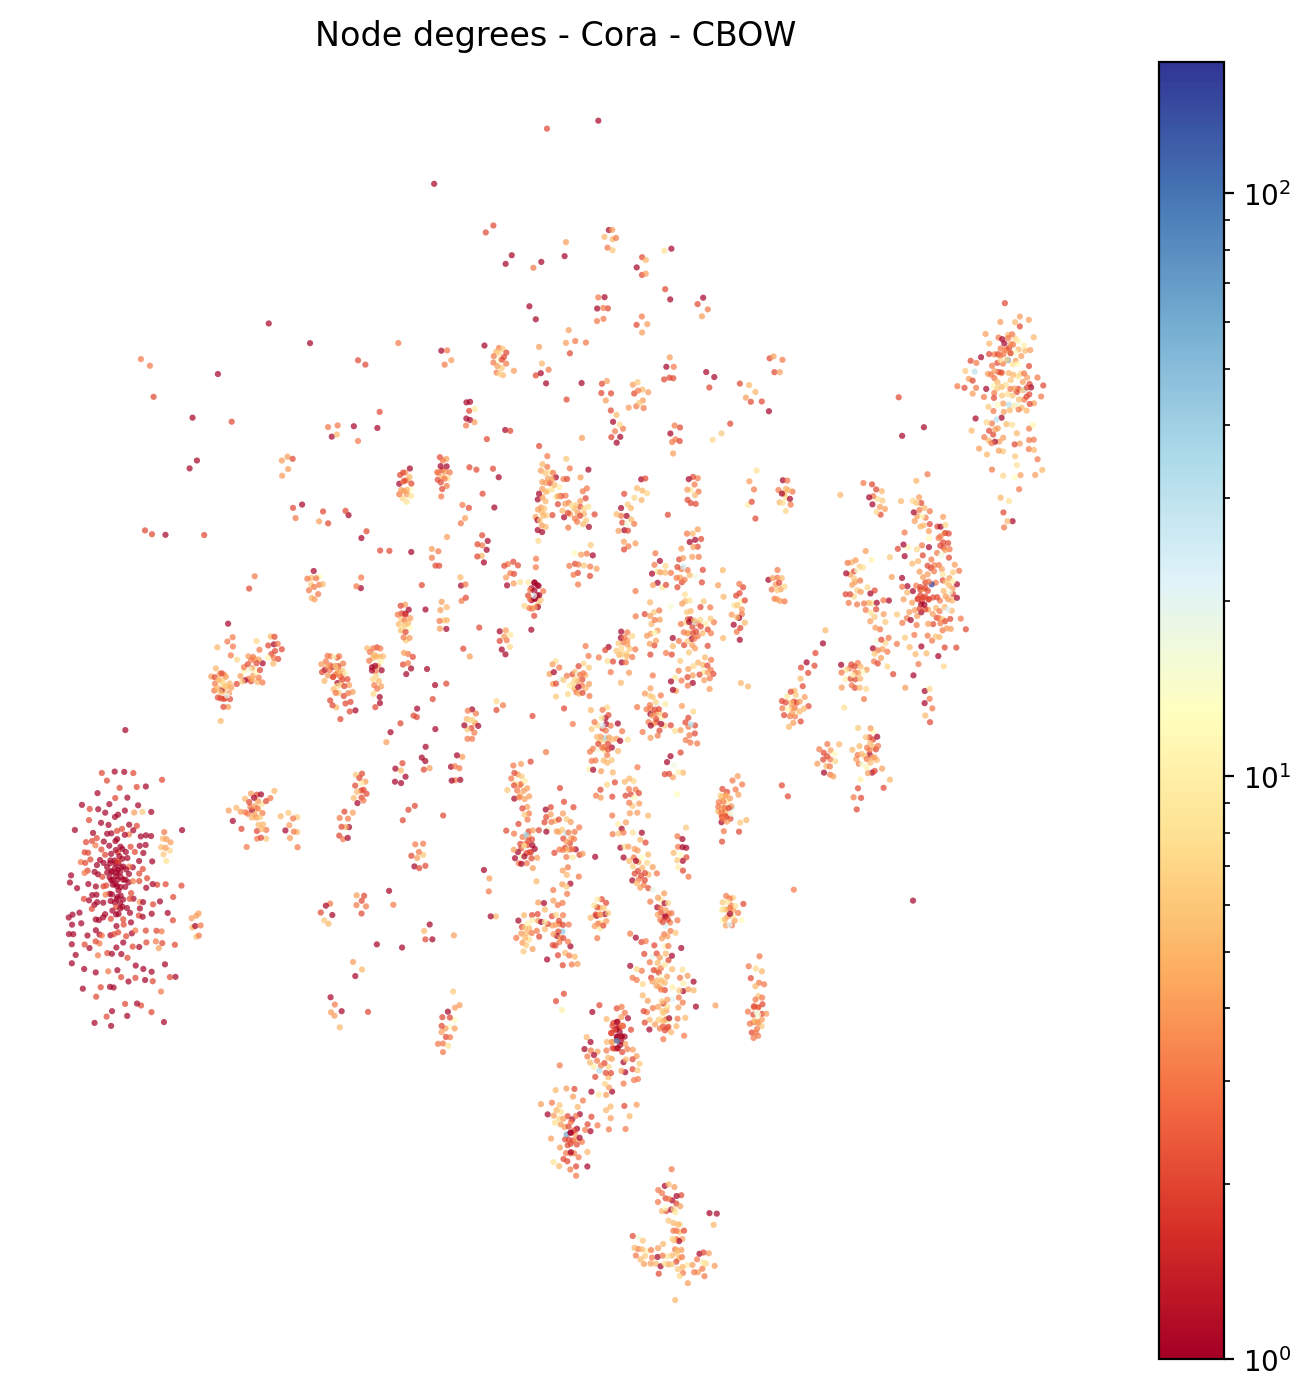

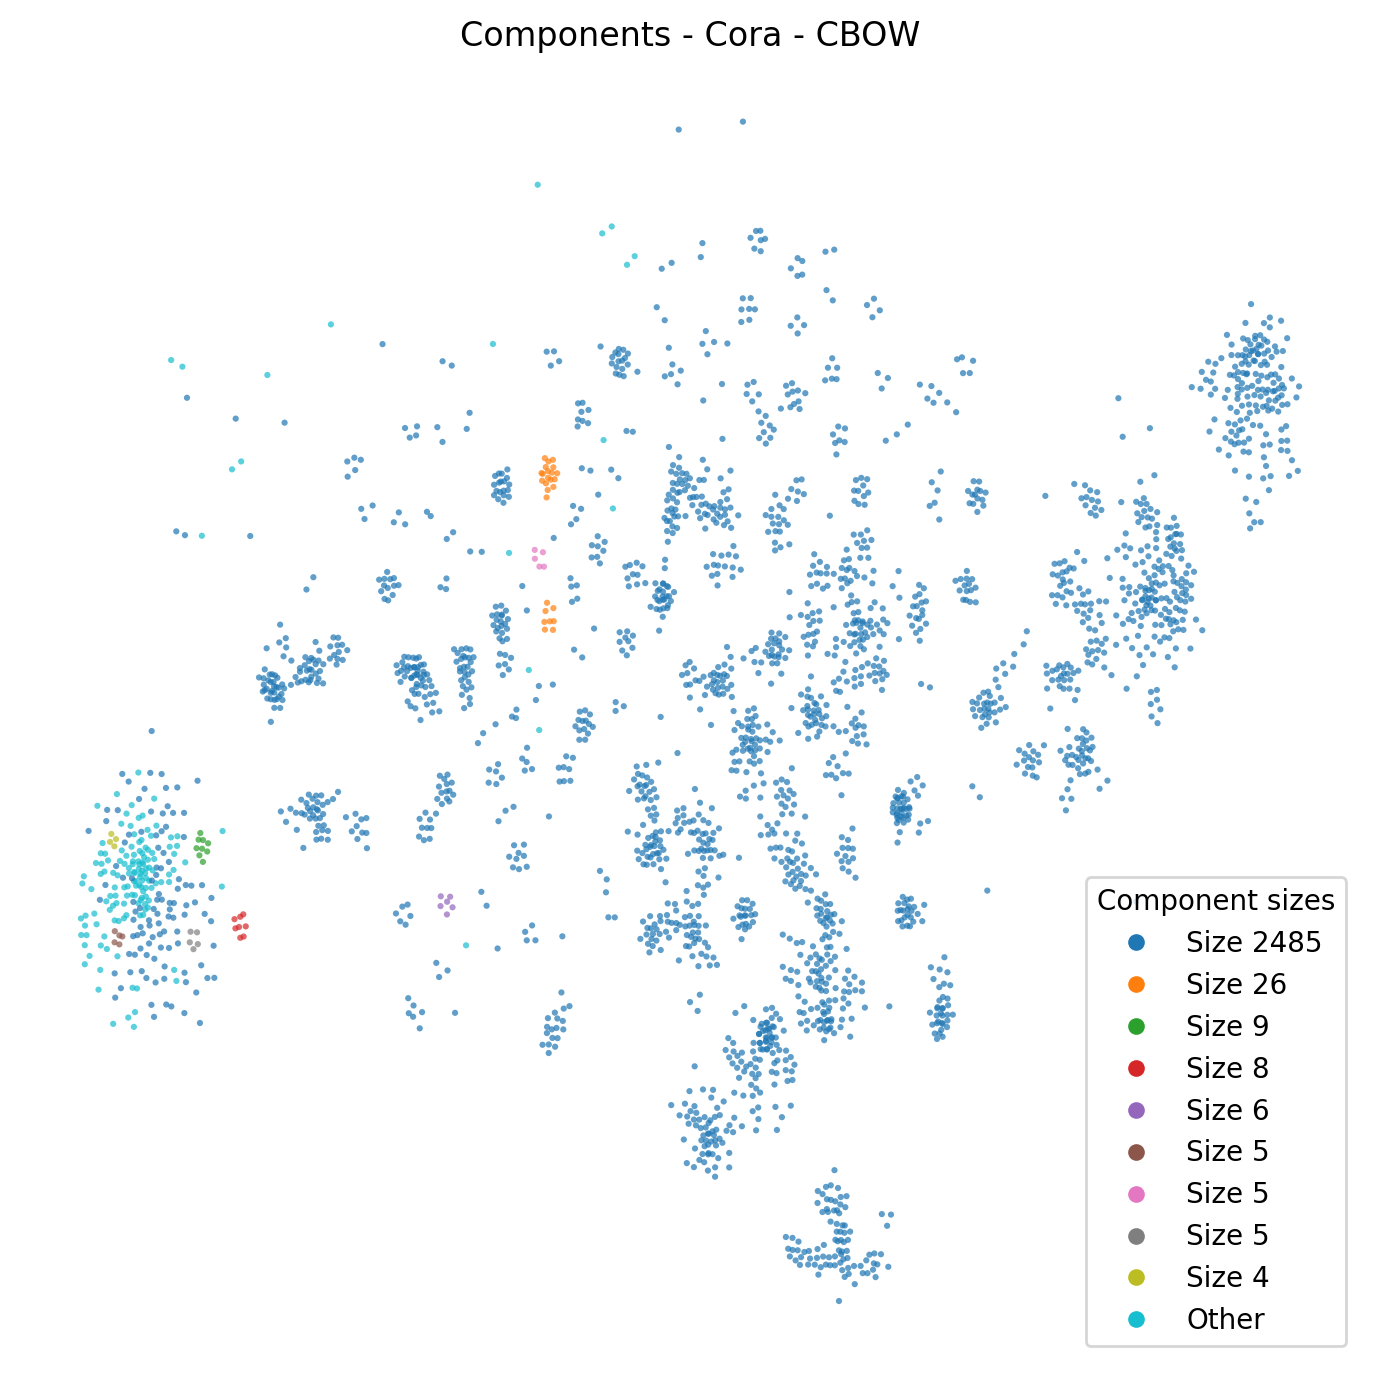

In [ ]:
visualizer.plot_node_types()
visualizer.plot_node_degrees()
visualizer.plot_connected_components()

In [ ]:
visualizer.fit_transform_nodes(second_order_rw_node_embedding)

(<Figure size 1400x1400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1504370810>)

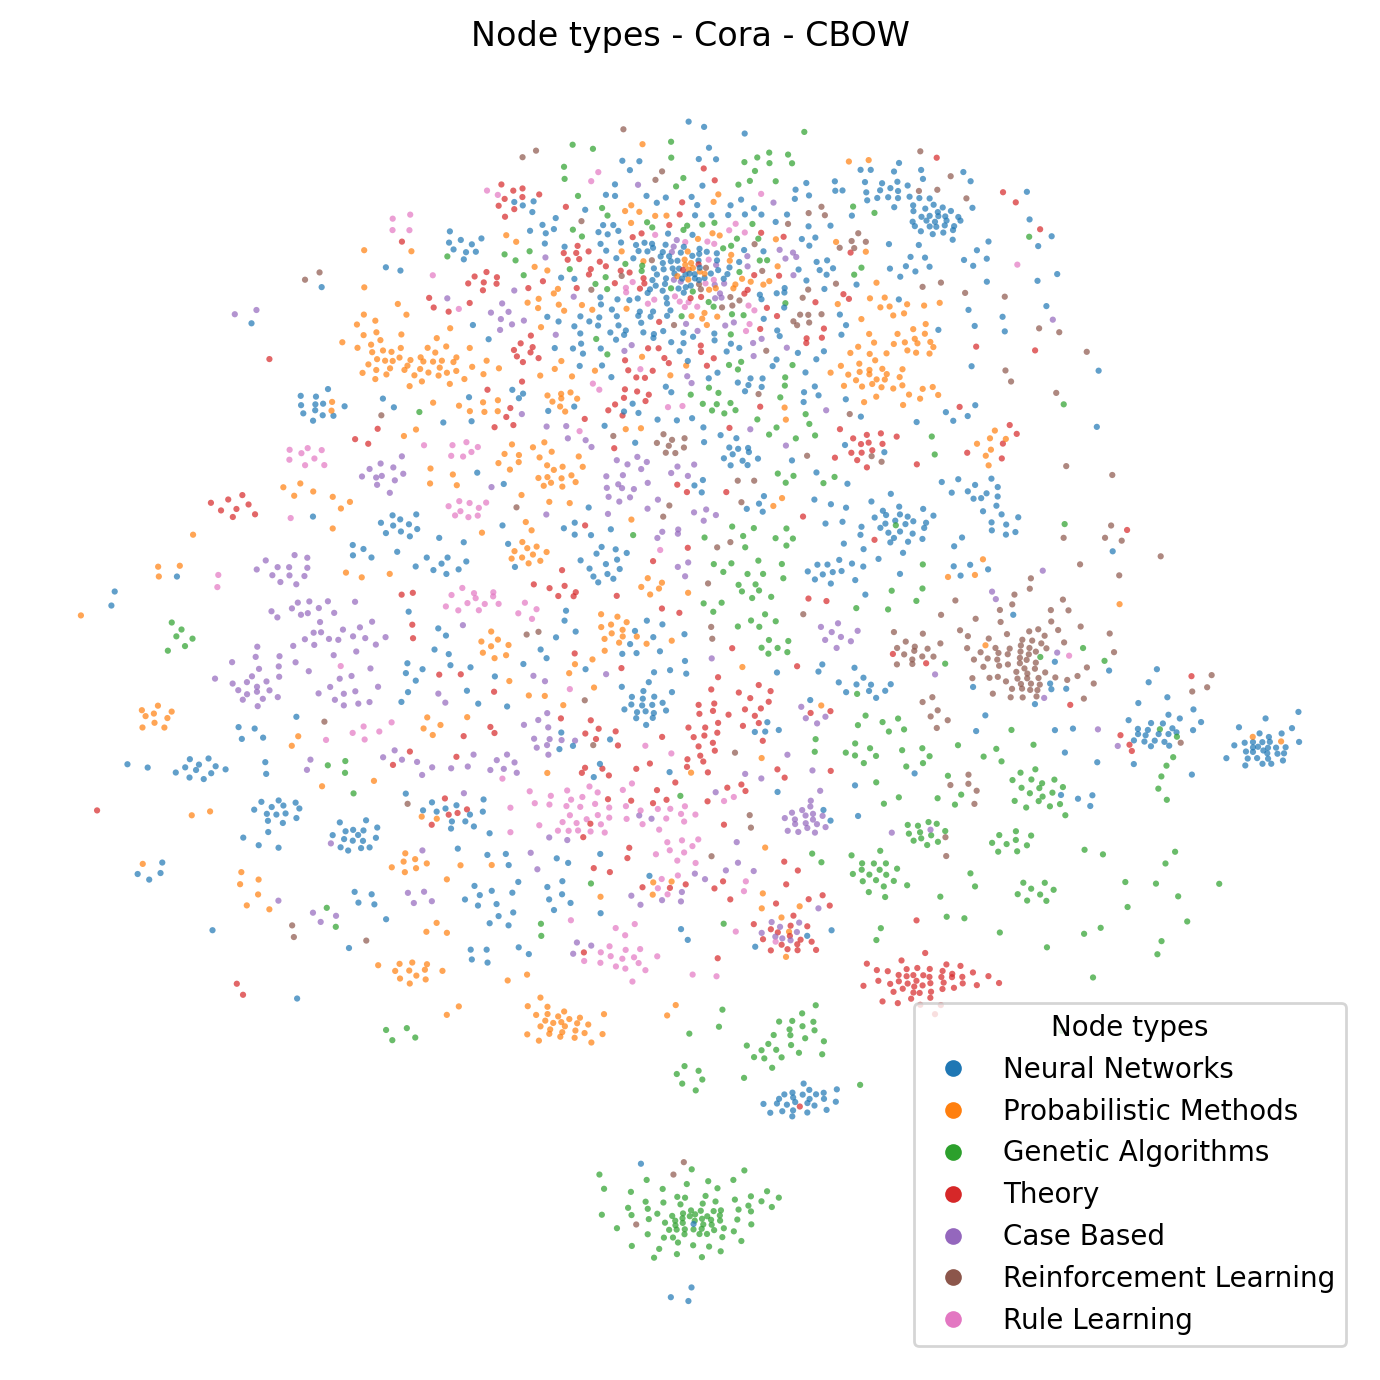

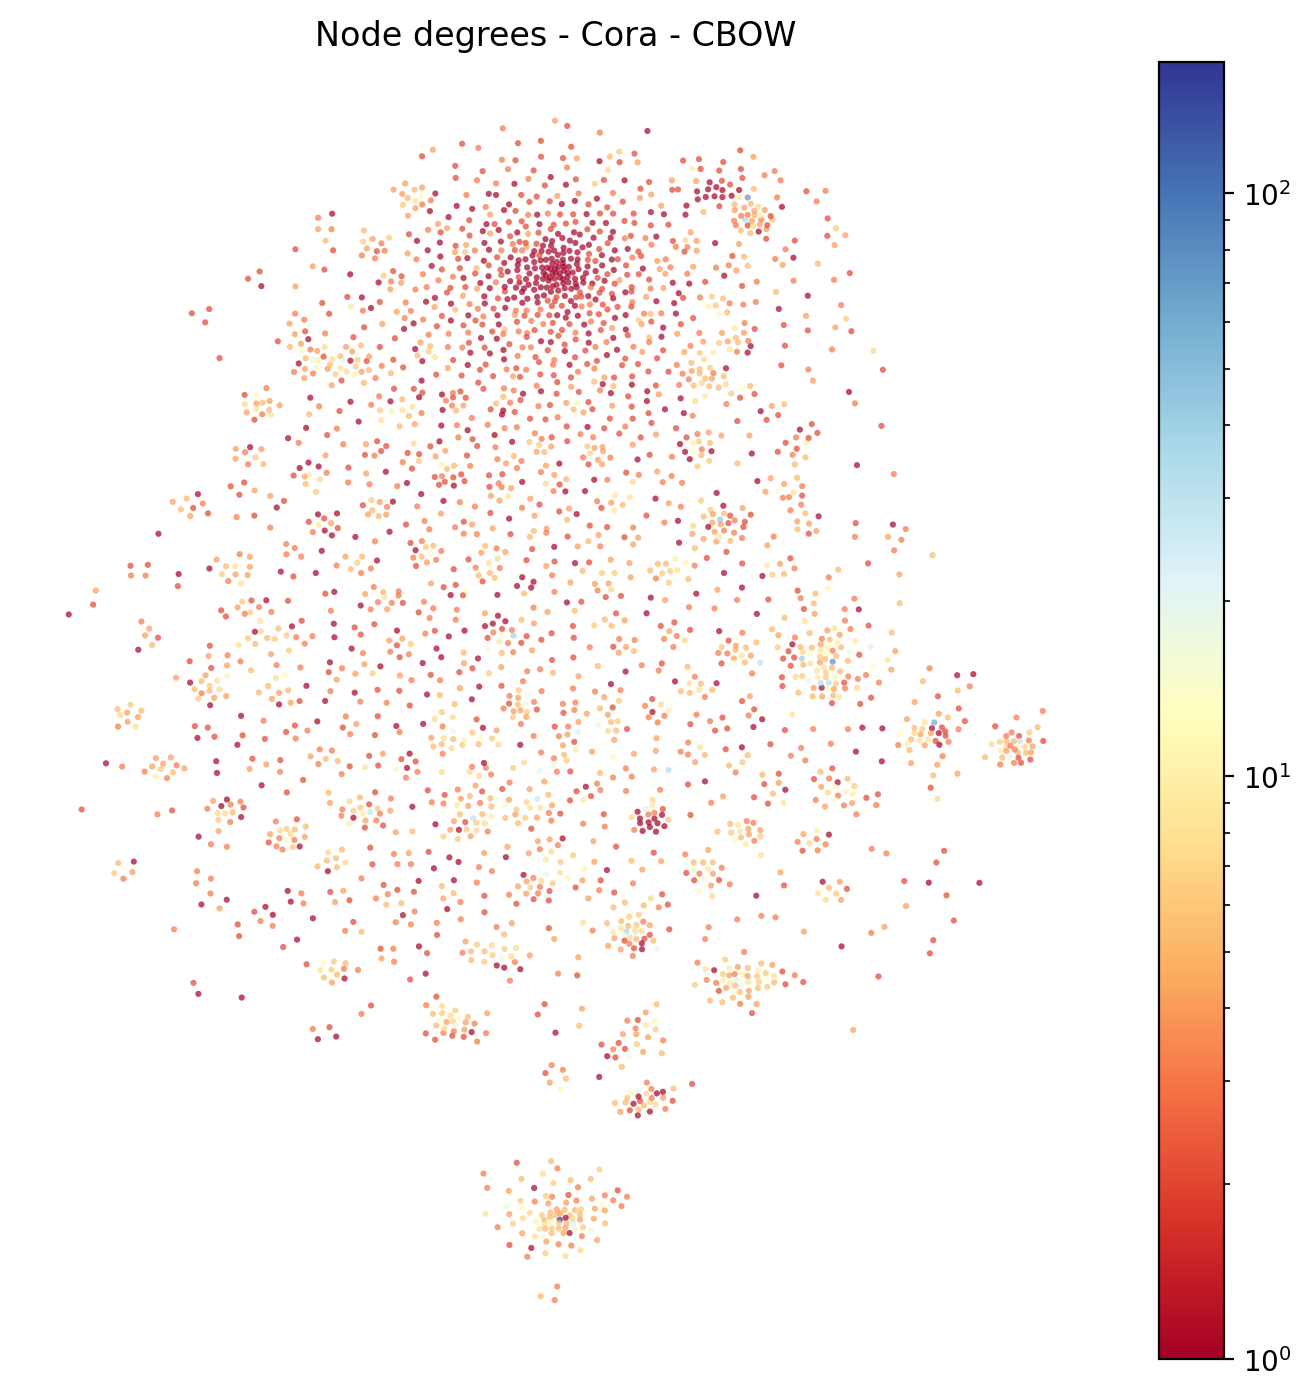

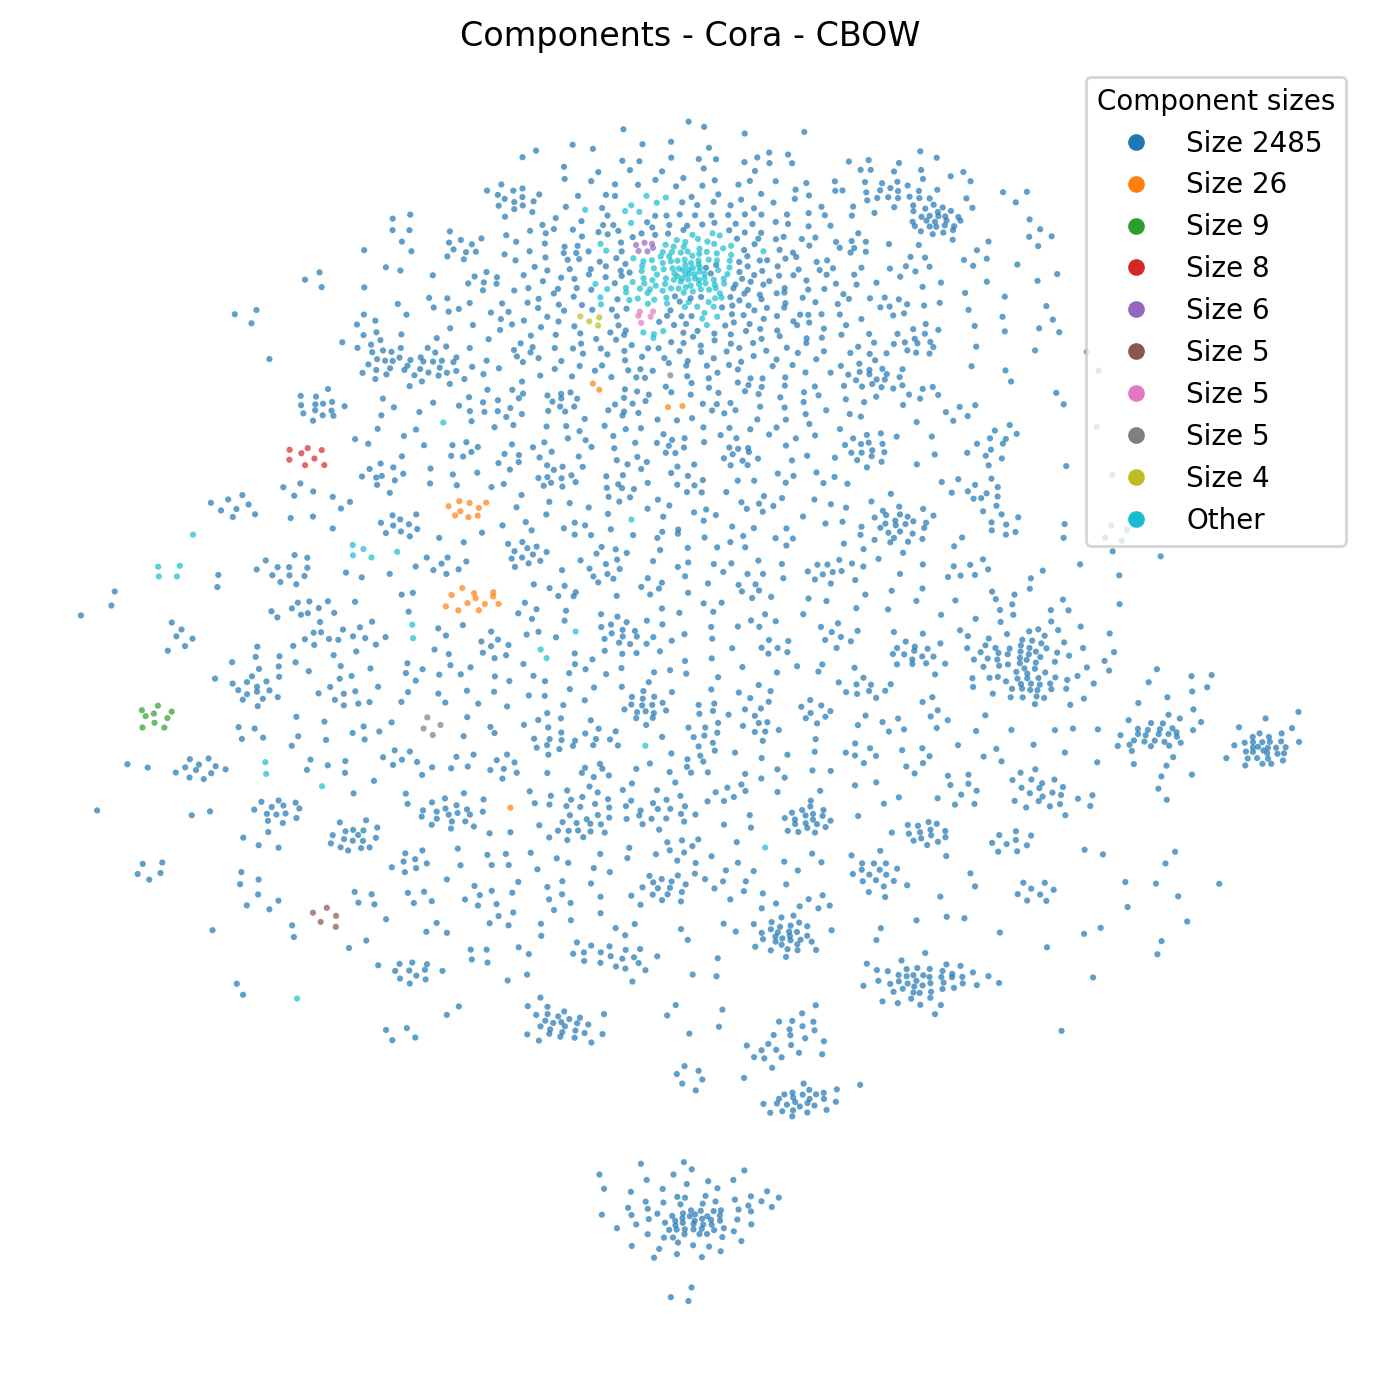

In [ ]:
visualizer.plot_node_types()
visualizer.plot_node_degrees()
visualizer.plot_connected_components()

### Visualizing the node features
Using the same visualization tool, we can also visualize the node features. 

Note that cudatsne only supports for now L2 distance, and generally cosine distance works better.

In [ ]:
visualizer.fit_transform_nodes(node_features)

(<Figure size 1400x1400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1514c07250>)

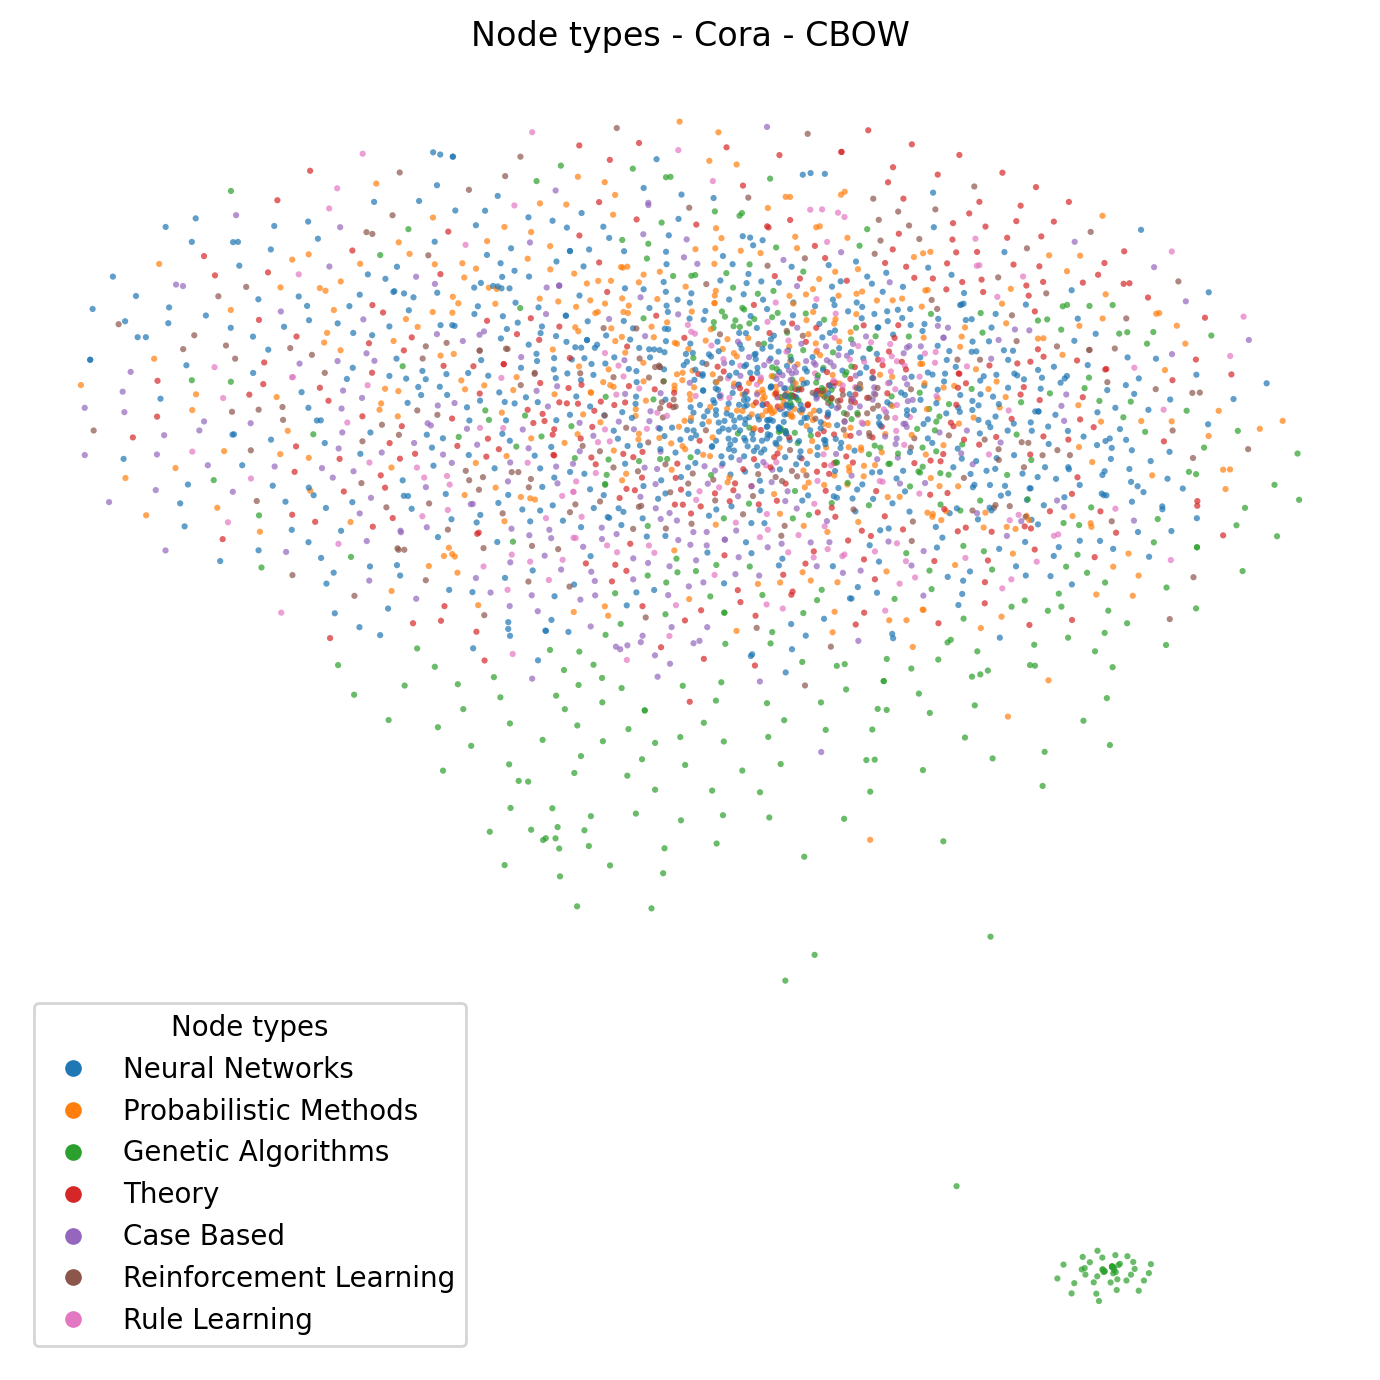

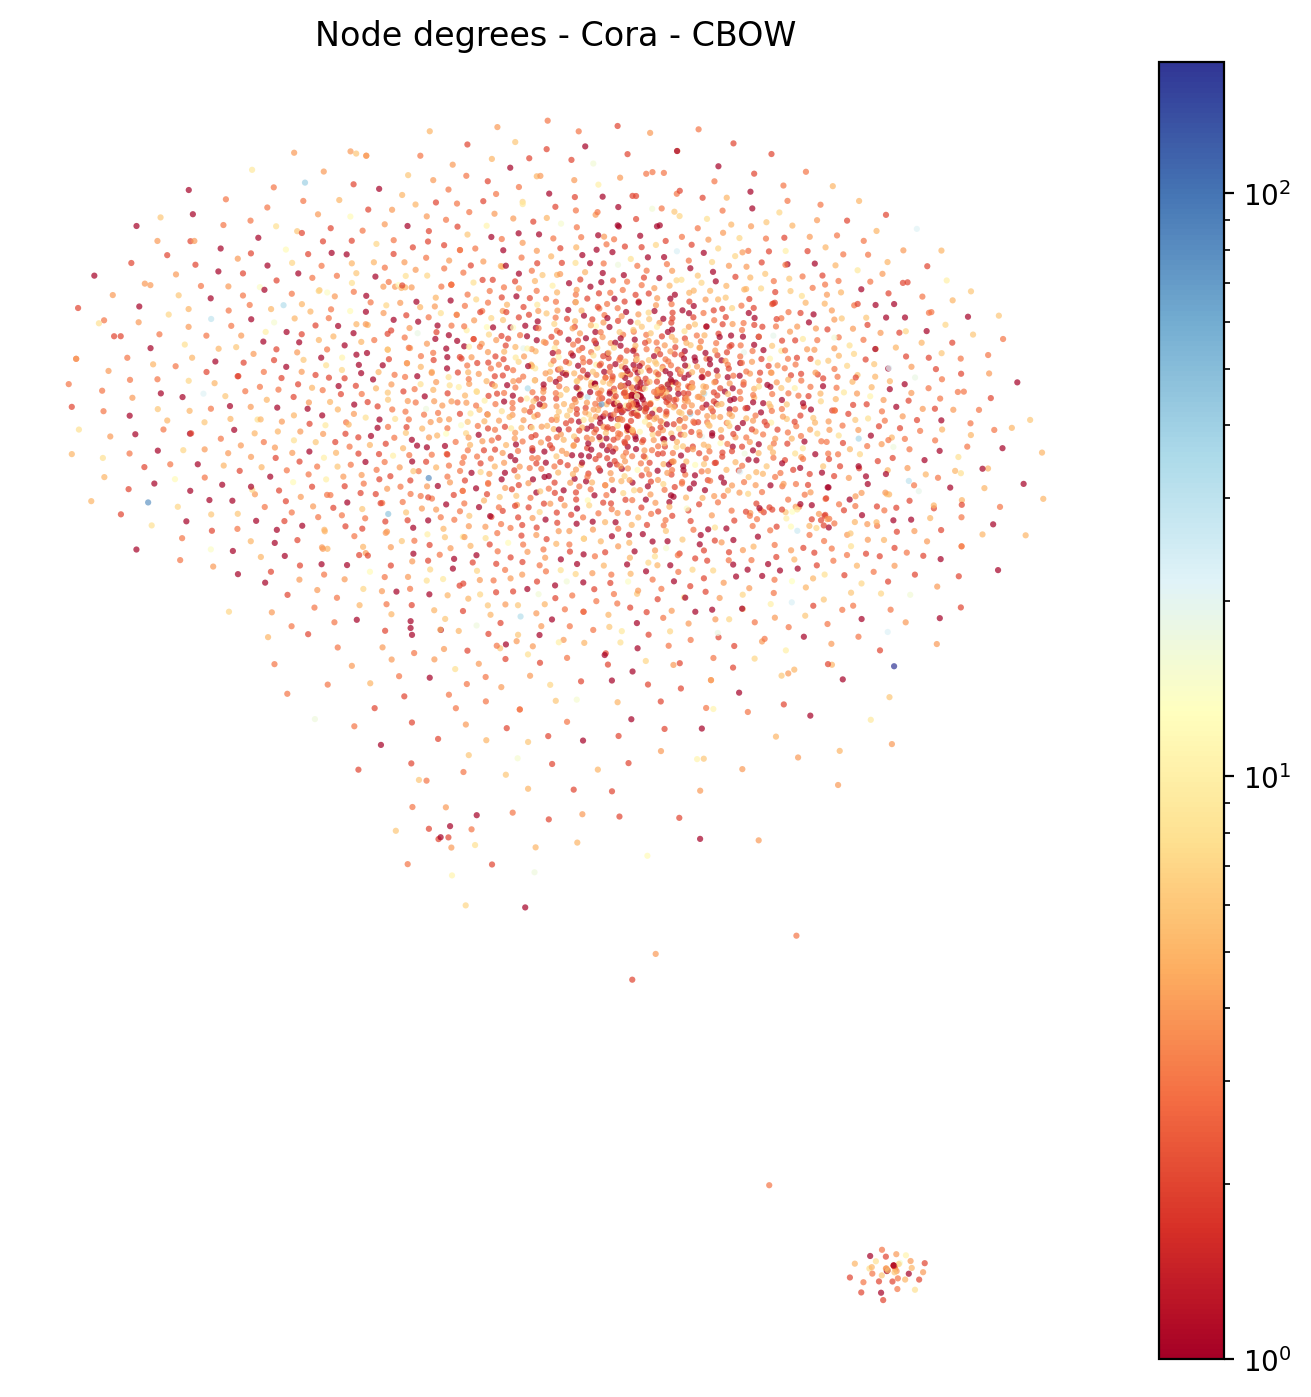

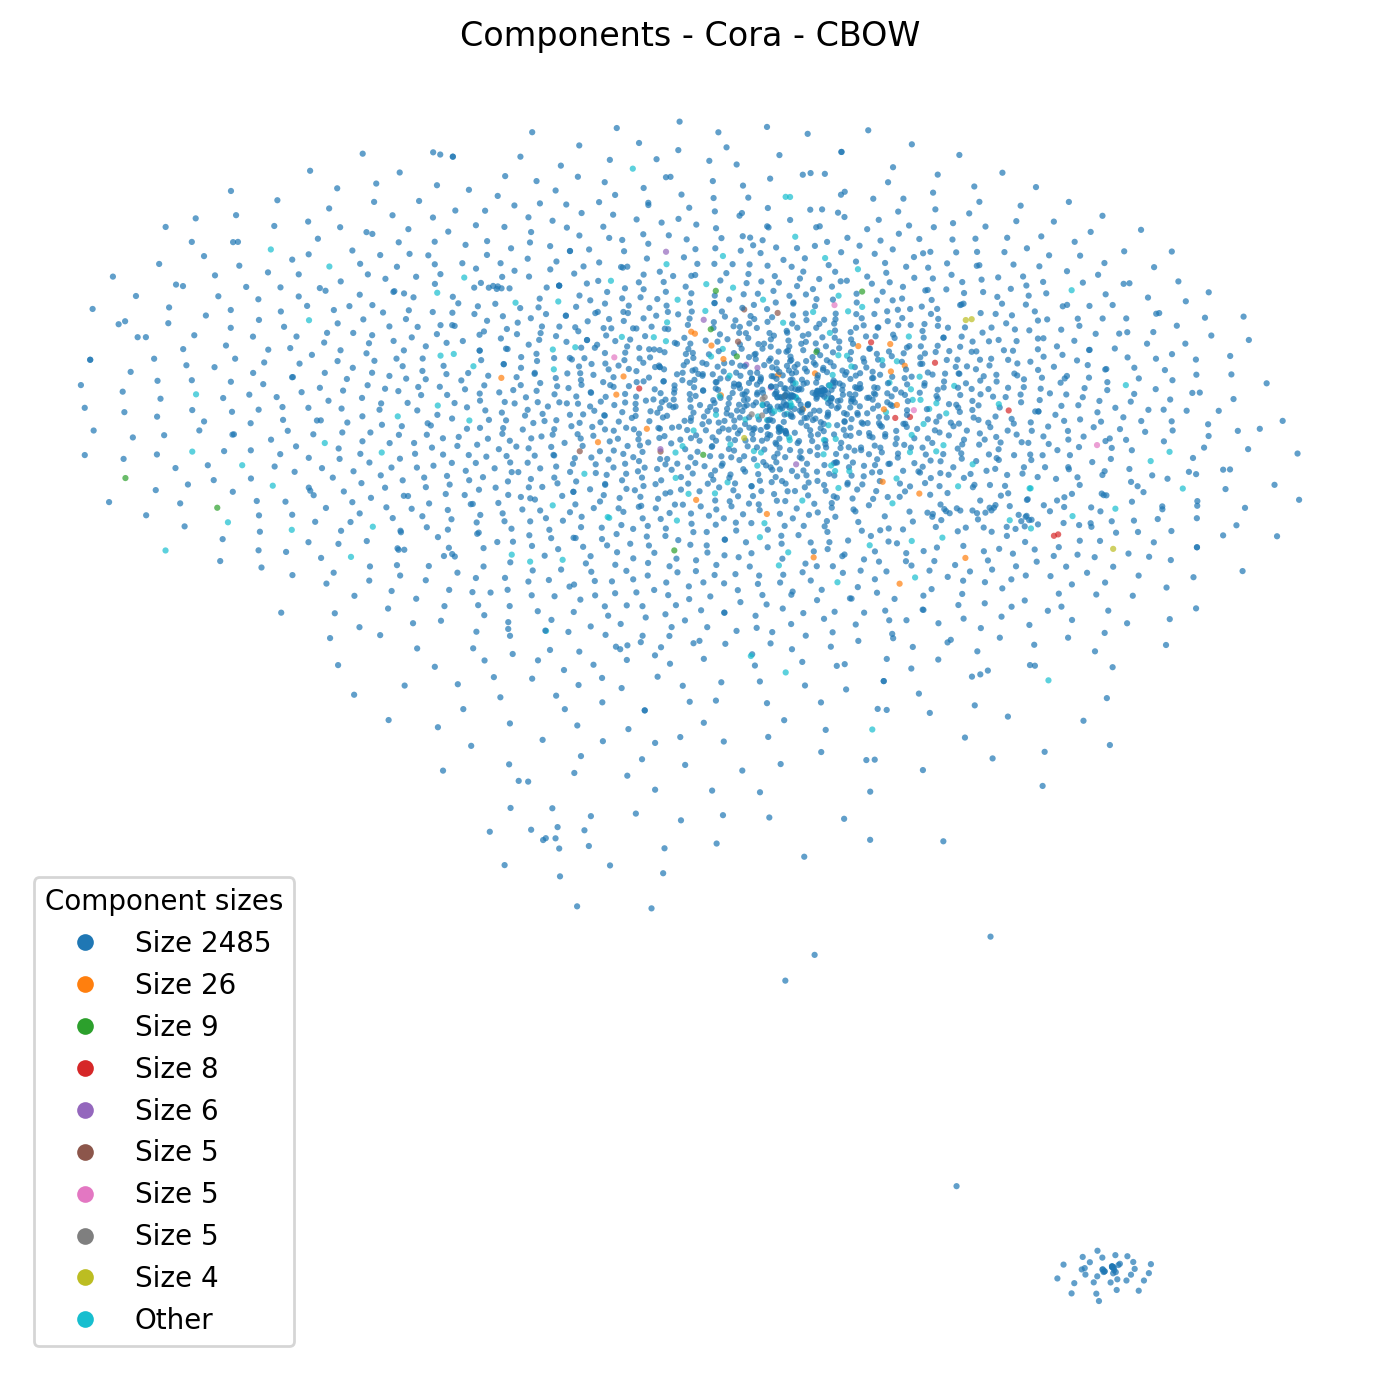

In [ ]:
visualizer.plot_node_types()
visualizer.plot_node_degrees()
visualizer.plot_connected_components()